Trained QGAN. Generator parameters: [ 0.01055747 -0.04357849  0.0332114   0.00976683  0.01676793  0.01623173
  0.00816052 -0.02478498]


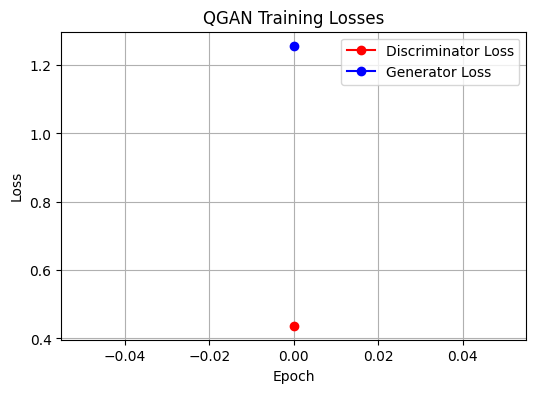

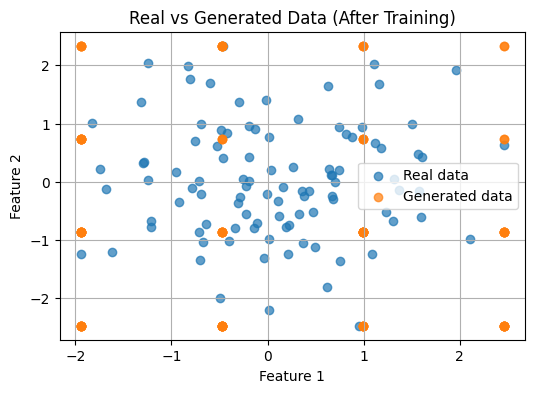

In [3]:
#-------------------------------------------------------------------------
# QGAN
# Chapter 8 in the QUANTUM COMPUTING AND QUANTUM MACHINE LEARNING BOOK
#-------------------------------------------------------------------------
# Version 1.1
# (c) 2025 Jesse Van Griensven, Roydon Fraser, and Jose Rosas
# License:  MIT - Citation of this work required
#-------------------------------------------------------------------------
# Qiskit changes frequently. 
# We recommend using the latest version from the book code repository at:
# https://github.com/pedroer/quantum-computing-for-engineers/blob/main/requirements.txt

import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import StateFn, CircuitSampler
from qiskit_machine_learning.algorithms import QGAN
import warnings
warnings.filterwarnings('ignore')

# 1) Simple Gaussian data generator
def gaussian(training_size, test_size, n_features):
    total = training_size + test_size
    data = np.random.randn(total, n_features)
    labels = np.zeros(total)
    return data[:training_size], labels[:training_size], data[training_size:], labels[training_size:]

# 2) Generate 2D training data
training_size = 100
test_size = 0
n_features = 2
training_data, _, _, _ = gaussian(training_size, test_size, n_features)
data = training_data

# 3) Compute data bounds
min_x, max_x = np.min(data[:, 0]), np.max(data[:, 0])
min_y, max_y = np.min(data[:, 1]), np.max(data[:, 1])
bounds = np.array([[min_x, max_x], [min_y, max_y]])

# 4) Initialize QGAN
qgan = QGAN(
    data,    # your real training data (shape (100, 2))
    bounds,  # shape (2,2)
    [2, 2],  # num_qubits: list of 2 ints for 2 features
    10,      # batch_size
    50       # epochs (or num_epochs)
)

# 5) Create QuantumInstance and train QGAN
quantum_instance = QuantumInstance(
    backend=Aer.get_backend('qasm_simulator'),
    shots=1024
)
result = qgan.run(quantum_instance=quantum_instance)
params_g = result['params_g']
print("Trained QGAN. Generator parameters:", params_g)

# 6) Plot training losses
loss_d = np.atleast_1d(result.get('loss_d', []))
loss_g = np.atleast_1d(result.get('loss_g', []))
epochs = range(len(loss_d))

plt.figure(figsize=(6,4))
plt.plot(epochs, loss_d, 'r-o', label='Discriminator Loss')
plt.plot(epochs, loss_g, 'b-o', label='Generator Loss')
plt.title('QGAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# 7) Sample from trained generator circuit
# Retrieve, bind parameters, and build state function
gen_circ = qgan.generator.generator_circuit
gen_bound = gen_circ.bind_parameters({p: v for p, v in zip(gen_circ.parameters, params_g)})
psi = StateFn(gen_bound)

# Convert to numeric state via CircuitSampler
sampler = CircuitSampler(quantum_instance)
statefn = sampler.convert(psi).eval()

# Extract amplitudes (may be sparse)
amplitudes = statefn.primitive
if hasattr(amplitudes, 'toarray'):
    amplitudes = np.array(amplitudes.toarray()).ravel()
else:
    amplitudes = np.array(amplitudes).ravel()
# Compute probabilities
probs = np.abs(amplitudes)**2
probs = probs / np.sum(probs)

# Build bit-string labels
total_qubits = sum(qgan._num_qubits)
bitstrings = [format(i, f'0{total_qubits}b') for i in range(len(probs))]

# Draw samples
shots = 100
indices = np.random.choice(len(probs), size=shots, p=probs)
drawn_bits = [bitstrings[i] for i in indices]

# Decode bit-strings back to 2D floats
def decode(bitstr):
    coords = []
    start = 0
    for dim, nq in enumerate(qgan._num_qubits):
        end = start + nq
        idx = int(bitstr[start:end], 2)
        mind, maxd = bounds[dim]
        coords.append(mind + idx/(2**nq - 1)*(maxd - mind))
        start = end
    return coords

generated_samples = np.array([decode(b) for b in drawn_bits])

# 8) Plot real vs generated samples
plt.figure(figsize=(6,4))
plt.scatter(data[:,0], data[:,1], alpha=0.7, label='Real data')
plt.scatter(generated_samples[:,0], generated_samples[:,1], alpha=0.7, label='Generated data')
plt.title('Real vs Generated Data (After Training)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.legend()
plt.show()



